In [63]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import SimpleRNN, Embedding, Dense
from tensorflow.keras.models import Sequential
from keras import backend as K 

In [14]:
# Fast Text pretrained
WIKI_KO_DATA = './data/cc.ko.300.bin.gz'

# Fast Text Embedding 모델
FT_EMBEDDING_PATH = f'./model/ft_embedding'

# 학습 데이터
DATA_PATH = './data/10000_data.tsv'

# 최종 모델
MODEL_PATH = './model/10000_doc_model'

In [12]:
if not os.path.exists('./model'):
    os.makedirs('./model')

### Gensim FastText
- cc.ko.300.bin.gz : [Fast Text에서 제공하는 위키백과 한국어 데이터](https://fasttext.cc/docs/en/crawl-vectors.html)

In [13]:
if os.path.isfile(FT_EMBEDDING_PATH):
    # 학습된 파일이 있는 경우
    print('trained model exist.')
    from gensim.models import FastText
    ko_model = FastText.load(FT_EMBEDDING_PATH)
    print('model loaded')
    
else:
    # 학습된 파일이 없는 경우
    print('start to train')
    from gensim import models
    if os.path.isfile(WIKI_KO_DATA):
        ko_model = models.fasttext.load_facebook_model(WIKI_KO_DATA)
        ko_model.save(FT_EMBEDDING_PATH)
        print('model saved')
    else:
        print('no wiki_ko_data. please download cc.ko.300.bin.gz from [https://fasttext.cc/docs/en/crawl-vectors.html]')

start to train
model saved


In [15]:
for w, sim in ko_model.wv.similar_by_word('파이썬', 10):
    print(f'{w}: {sim}')

Python: 0.565061628818512
자이썬: 0.5624369382858276
레일스: 0.5598082542419434
파이썬을: 0.5595801472663879
언어용: 0.5288202166557312
파이썬의: 0.5250024795532227
프로그래밍: 0.5225088000297546
wxPython: 0.5222088098526001
파이썬이나: 0.5201171636581421
함수형: 0.5187377333641052


In [16]:
print(f'vocab size : {len(ko_model.wv.vocab)}')

vocab size : 2000000


In [17]:
data = pd.read_csv(DATA_PATH, sep='\t', usecols=['label', 'sentence'])
data.sample(5)

,label,sentence
3583,1,aaa authentication authorization accounting 1 ...
1508,1,마이크로 서비스 전환시 알아야 할 것 어떤 서비스를 만들때에 monolithic으로...
3310,1,apache 24 flask 설정방법 아파치에서 flask로 만들어진 어플리케이션을...
9976,1,angular 하이브리드앱 개발 1 ionic framework 개발환경 구축 io...
872,1,javascript 모던자바스크립트 4 코드구조 이 글은 번역 및 정리 글입니다 출...


In [18]:
data.sentence

0       todo 리스트를 1달간 사용해본 후기 왜 todo 리스트를 사용했나요 위 질문에 ...
1       양평 블룸비스타 콩순이 패밀리룸이 궁금하신분에게 드리는 후기 늦은 여름 휴가로 양평...
2       javascript js 자바스크립트 문자열 메소드 javascript 문자열 메소...
3       우리 시장에는 어떤 교육이 필요할까요 1 시장적합형 교육과 기술적합형 교육 며칠전 ...
4       저 많은 국민은행 앱들은 대체 다 어디다 쓰는 걸까 대략 정리 구글플래이 스토어에서...
                              ...                        
9995    nginx rest kubernetes 164 kubernetes nginx ing...
9996    git https javascript html web ui modal design ...
9997    spring boot spring spring boot오류 처리에 대해 서론오류 처...
9998    http3 http3 httpoverquic quic은 quick udp inter...
9999    spring kotlin kotlin spring boot security thym...
Name: sentence, Length: 10000, dtype: object

In [19]:
def sentenceToVector(sentence):
    words = sentence.split(' ')
    words_num = len(words)
    vector = np.zeros(300) # ko_model shape가 300
    for word in words:
        vector += ko_model[word]
    return vector/words_num
data['vector'] = data.sentence.apply(sentenceToVector)

/Users/nero/.virtualenvs/dc/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [20]:
def numberToOneHot(num):
    oneHot = [0]*2
    oneHot[num] = 1
    return oneHot

data['oneHot'] = data.label.apply(numberToOneHot)

In [21]:
data.head(3)

,label,sentence,vector,oneHot
0,1,todo 리스트를 1달간 사용해본 후기 왜 todo 리스트를 사용했나요 위 질문에 ...,"[0.013710441264420491, 0.0032995063650540692, ...","[0, 1]"
1,0,양평 블룸비스타 콩순이 패밀리룸이 궁금하신분에게 드리는 후기 늦은 여름 휴가로 양평...,"[0.00013062362416590355, -0.032540909874690126...","[1, 0]"
2,1,javascript js 자바스크립트 문자열 메소드 javascript 문자열 메소...,"[-0.04456514536979653, 0.00961365589007203, 0....","[0, 1]"


In [22]:
data.vector[0].shape

(300,)

In [93]:
X_train, X_test, y_train, y_test = train_test_split(data.vector, data.label, test_size=0.33, random_state=321)

In [94]:
def reshape(series, embedding_dim):
    result = np.array(series.tolist())
    result = result.reshape(result.shape[0], embedding_dim, 1)
    return result

In [95]:
X_train = reshape(X_train, 300)
X_test = reshape(X_test, 300)
print(f'X_train shape = {X_train.shape} / X_test shape = {X_test.shape}')

X_train shape = (6700, 300, 1) / X_test shape = (3300, 300, 1)


In [108]:
def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [110]:
K.clear_session()

model = Sequential()
# model.add(Embedding(len(ko_model.wv.vocab), 300)) # 임베딩 벡터의 차원은 300 <- fast text쓰므로 안씀
model.add(Dense(300, input_shape=(X_train.shape[1], 1), activation="relu"))
model.add(SimpleRNN(32))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc',f1_m,precision_m, recall_m])
history = model.fit(X_train, np.asarray(y_train), epochs=10, batch_size=100, validation_split=0.3)

Train on 4690 samples, validate on 2010 samples
Epoch 1/10
4690/4690 [==============================] - 11s 2ms/sample - loss: 0.5929 - acc: 0.7068 - f1_m: 0.8149 - precision_m: 0.7111 - recall_m: 0.9598 - val_loss: 0.5721 - val_acc: 0.7264 - val_f1_m: 0.8332 - val_precision_m: 0.7167 - val_recall_m: 1.0000
Epoch 2/10
4690/4690 [==============================] - 9s 2ms/sample - loss: 0.5536 - acc: 0.7318 - f1_m: 0.8443 - precision_m: 0.7314 - recall_m: 0.9997 - val_loss: 0.5431 - val_acc: 0.7313 - val_f1_m: 0.8347 - val_precision_m: 0.7224 - val_recall_m: 0.9935
Epoch 3/10
4690/4690 [==============================] - 9s 2ms/sample - loss: 0.5041 - acc: 0.7567 - f1_m: 0.8548 - precision_m: 0.7580 - recall_m: 0.9836 - val_loss: 0.4873 - val_acc: 0.7602 - val_f1_m: 0.8475 - val_precision_m: 0.7562 - val_recall_m: 0.9691
Epoch 4/10
4690/4690 [==============================] - 9s 2ms/sample - loss: 0.4594 - acc: 0.7808 - f1_m: 0.8628 - precision_m: 0.7921 - recall_m: 0.9506 - val_loss: 0.46

In [112]:
# evaluate the model
loss, accuracy, f1_score, precision, recall = model.evaluate(X_test, np.asarray(y_test), verbose=0)

In [114]:
print(f'f1_score : {f1_score} / precision : {precision} / recall : {recall}')

f1_score : 0.8733237981796265 / precision : 0.8236654996871948 / recall : 0.9343108534812927


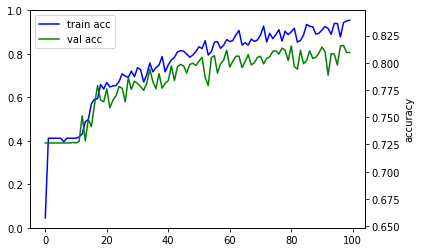

In [106]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

acc_ax.plot(history.history['acc'], 'b', label='train acc')
acc_ax.plot(history.history['val_acc'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper left')

plt.show()

In [107]:
model.save(MODEL_PATH)

INFO:tensorflow:Assets written to: ./model/10000_doc_model/assets


In [ ]:
model.predict('')